In [7]:
import numpy as np
import nibabel as nib
import nibabel.orientations as nio
from scipy.ndimage import center_of_mass
import os
import numpy as np
from tqdm import tqdm

def reorient_to(img, axcodes_to=('P', 'I', 'R'), verb=False):
    """Reorients the nifti from its original orientation to another specified orientation
    
    Parameters:
    ----------
    img: nibabel image
    axcodes_to: a tuple of 3 characters specifying the desired orientation
    
    Returns:
    ----------
    newimg: The reoriented nibabel image 
    
    """
    aff = img.affine
    ornt_fr = nio.io_orientation(aff)
    axcodes_fr = nio.ornt2axcodes(ornt_fr)
    if axcodes_to == axcodes_fr:
        return img
    ornt_to = nio.axcodes2ornt(axcodes_to)
    arr = np.asanyarray(img.dataobj, dtype=img.dataobj.dtype)
    ornt_trans = nio.ornt_transform(ornt_fr, ornt_to)
    arr = nio.apply_orientation(arr, ornt_trans)
    aff_trans = nio.inv_ornt_aff(ornt_trans, arr.shape)
    newaff = np.matmul(aff, aff_trans)
    newimg = nib.Nifti1Image(arr, newaff)
    if verb:
        print("[*] Image reoriented from", nio.ornt2axcodes(ornt_fr), "to", axcodes_to)
    return newimg



# Directories ubuntu
# base_dir = "/home/awias/data/Totalsegmentator_dataset_v201"
# savepath_root = "/home/awias/data/Totalsegmentator_dataset_v201_filtered_liver"

# Directories titans
base_dir = "/scratch/awias/data/Totalsegmentator_dataset_v201"
savepath_root = "/scratch/awias/data/Totalsegmentator_dataset_v201_filtered_pancreas"

os.makedirs(savepath_root, exist_ok=True)

# Get all subject folders (s0000, s0001, ...)
subjects = sorted([d for d in os.listdir(base_dir) if d.startswith("s")])

idx = 0

# subjects = ['s0001']

list_of_organs = {'pancreas': 1, 'gallbladder': 2, 'duodenum': 3, 'adrenal_gland_left': 4}

for subj in tqdm(subjects):
    ct_path = os.path.join(base_dir, subj, "ct.nii.gz")
    
    combined_seg_arr = None

    for organ, organ_id in list_of_organs.items():
        seg_path = os.path.join(base_dir, subj, "segmentations", f"{organ}.nii.gz")
        seg_nib = nib.load(seg_path)
        seg_arr = seg_nib.get_fdata(dtype=np.float32)
        if np.max(seg_arr) == 1:
            if combined_seg_arr is None:
                combined_seg_arr = np.zeros_like(seg_arr)
            combined_seg_arr[seg_arr == 1] = organ_id
            print("YEAH")
            print(subj, organ)

    if combined_seg_arr is None:
            print(f"Skipping {subj}: No organ segmentation found")
            continue
    else:
        break

  0%|          | 1/1228 [00:00<05:07,  3.99it/s]

Skipping s0000: No organ segmentation found
YEAH
s0001 pancreas
YEAH
s0001 duodenum
YEAH
s0001 adrenal_gland_left


In [8]:
print(np.any(combined_seg_arr == 1))
print(np.any(combined_seg_arr == 2))
print(np.any(combined_seg_arr == 3))
print(np.any(combined_seg_arr == 4))


True
False
True
True


In [11]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
from matplotlib.patches import Patch

def plot_central_slice_mask(mask, spacing=None, title=None, output_path=None):
    """
    Plot central slice of mask

    input:
        mask: mask (numpy)
        spacing: image spacing (numpy)
        title: plot title (str)
    """

    unique_classes = np.unique(mask)
    unique_classes = unique_classes[unique_classes != 0]

    colors = ["black"] + [plt.cm.tab10(i) for i in range(len(unique_classes))]
    cmap = mcolors.ListedColormap(colors)
    bounds = np.concatenate(([0], unique_classes))
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(bounds) + 1) - 0.5, ncolors=len(bounds))

    if spacing is None:
        spacing = np.ones(3)

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(mask[mask.shape[0] // 2].T, cmap=cmap, norm=norm, origin="lower")
    ax[0].set_title('Sagittal')
    ax[0].set_aspect(spacing[2] / spacing[1])
    ax[1].imshow(mask[:, mask.shape[1] // 2].T, cmap=cmap, norm=norm, origin="lower")
    ax[1].set_title('Coronal')
    ax[1].set_aspect(spacing[2] / spacing[0])
    ax[2].imshow(mask[:, :, mask.shape[2] // 2].T, cmap=cmap, norm=norm, origin="lower")
    ax[2].set_title('Axial')
    ax[2].set_aspect(spacing[1] / spacing[0])

    if title is not None:
        fig.suptitle(title)

    if output_path is not None:
        fig.savefig(output_path)
        print(f"Saved figure to: {output_path}")
    else:
        plt.show()

    plt.close()

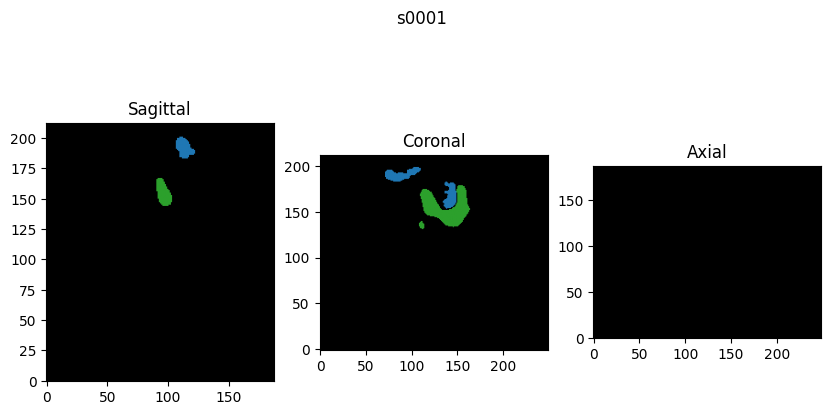

In [13]:
plot_central_slice_mask(combined_seg_arr, title=subj)